# 0) Постановка задачи
База данный фильмов (TMDb) представляет собой комплексную базу данных,которая предоставляет информацию о фильмах, включая такие подробности, как названия, рейтинги, даты выпуска, доходы, жанры и многое другое.
Этот набор данных содержит коллекцию из 930 000 фильмов из базы данных TMDB, собранных и очищенных в октябре 2023 года.

Решаться будет задача регрессии: прогнозировать рейтинги фильмов по их жанрам.

# 1) Чтение данных

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import drive
%matplotlib inline

Так как датасет весит более 25 МБ, для чтения будет использоваться облачное хранилище Google Drive.

In [33]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
db_file = '/content/drive/My Drive/data_base/TMDB_movie_dataset_v11.csv'
db = pd.read_csv(db_file)
db.shape

(951126, 23)

Дата сет содержит 23 признака и 951126 строк данных

In [35]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951126 entries, 0 to 951125
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    951126 non-null  int64  
 1   title                 951115 non-null  object 
 2   vote_average          951126 non-null  float64
 3   vote_count            951126 non-null  int64  
 4   status                951126 non-null  object 
 5   release_date          861299 non-null  object 
 6   revenue               951126 non-null  int64  
 7   runtime               951126 non-null  int64  
 8   adult                 951126 non-null  bool   
 9   backdrop_path         278149 non-null  object 
 10  budget                951126 non-null  int64  
 11  homepage              103643 non-null  object 
 12  imdb_id               557450 non-null  object 
 13  original_language     951126 non-null  object 
 14  original_title        951115 non-null  object 
 15  

В признаках присутствуют такие, которые не будут влиять на классификацию, поэтому их можно убрать. Также, стоит убрать фильмы которые ещё не вышли, так как сформированный рейтинг на трейлерах или описаний может не соотвествовать ожиданий.

In [36]:
db = db.loc[db['status'] == "Released"]
db = db.drop(db.columns[[0, 3, 4, 6, 9, 11, 12, 14, 15, 16, 17, 18]], axis = 1)
cat_indexes = [4, 6, 7, 10]
db.iloc[:, cat_indexes] = db.iloc[:, cat_indexes].astype('category')
db.info()

<ipython-input-36-5b27d77c50a8>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  db.iloc[:, cat_indexes] = db.iloc[:, cat_indexes].astype('category')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 937626 entries, 0 to 951125
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   title                 937617 non-null  object  
 1   vote_average          937626 non-null  float64 
 2   release_date          858429 non-null  object  
 3   runtime               937626 non-null  int64   
 4   adult                 937626 non-null  category
 5   budget                937626 non-null  int64   
 6   original_language     937626 non-null  category
 7   genres                603504 non-null  category
 8   production_companies  454474 non-null  object  
 9   production_countries  569863 non-null  object  
 10  spoken_languages      575614 non-null  category
dtypes: category(4), float64(1), int64(2), object(4)
memory usage: 64.1+ MB


Для упрощения прогноза, дату релиза фильмов будем использовать по годам.

In [37]:
right_date = []
year = []
for date in db['release_date']:
  if not pd.isna(date) and date != 'nan':
    year = date.split('-')
    right_date.append(int(float(year[0])))
  else:
    right_date.append(0)
db['release_date'] = right_date
db.iloc[:, 2] = db.iloc[:, 2].astype('int64')

In [38]:
db.head()

,title,vote_average,release_date,runtime,adult,budget,original_language,genres,production_companies,production_countries,spoken_languages
0,Inception,8.364,2010,148,False,160000000,en,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili"
1,Interstellar,8.417,2014,169,False,165000000,en,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English
2,The Dark Knight,8.512,2008,152,False,185000000,en,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin"
3,Avatar,7.573,2009,162,False,237000000,en,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish"
4,The Avengers,7.710,2012,143,False,220000000,en,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian"


# 2) Визуализация данных и вычисление основных характеристик
Для количественных данных найдём основные хар-ки.

In [39]:
db_des = db.describe()
db_des

,vote_average,release_date,runtime,budget
count,937626.000000,937626.000000,937626.000000,9.376260e+05
mean,2.231056,1829.876724,52.092007,2.999736e+05
std,3.153920,556.395382,62.490512,4.962999e+06
min,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,1977.000000,2.000000,0.000000e+00
50%,0.000000,2007.000000,40.000000,0.000000e+00
75%,5.278000,2017.000000,90.000000,0.000000e+00
max,10.000000,2026.000000,14400.000000,8.880000e+08


Построим матрицу корреляции.

In [40]:
cor_mat = db_des.corr()
cor_mat

,vote_average,release_date,runtime,budget
vote_average,1.000000,0.999997,0.999885,-0.142780
release_date,0.999997,1.000000,0.999892,-0.142136
runtime,0.999885,0.999892,1.000000,-0.127738
budget,-0.142780,-0.142136,-0.127738,1.000000


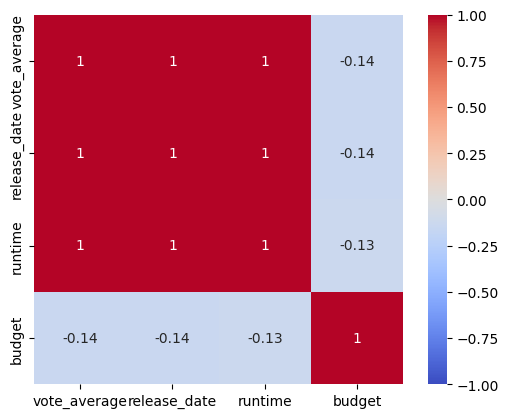

In [41]:
sns.heatmap(cor_mat, square=True, annot=True, cmap='coolwarm', vmin=-1.0, vmax=1.0)
pass

Большую корреляцию можно наблюдать между значениями "Средний рейтинг", "Дата релиза" и "Продолжительность". Для проверки построим диаграммы рассеиваний.

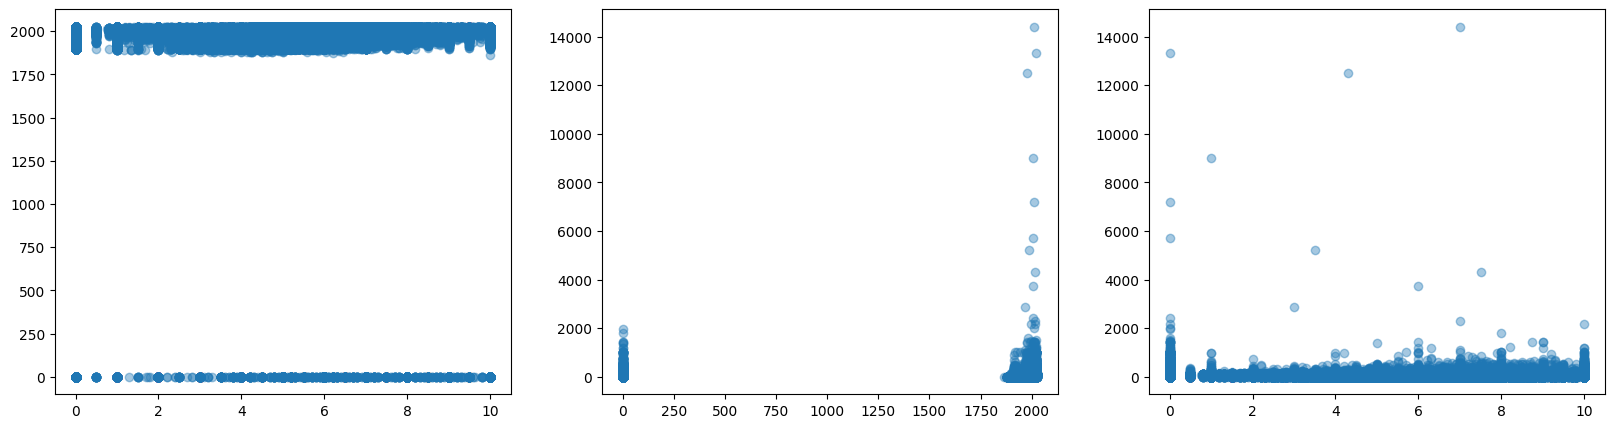

In [42]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
axes[0].scatter(db['vote_average'], db['release_date'],    alpha = 0.4)
axes[1].scatter(db['release_date'], db['runtime'],   alpha = 0.4)
axes[2].scatter(db['vote_average'], db['runtime'],    alpha = 0.4)

По диаграммам можно заметить, что присуствуюет большое кол-во нулевых значений в каждом признаке, что не позволяет найти закономерности. Построим новые, без учёта нулевых значений.

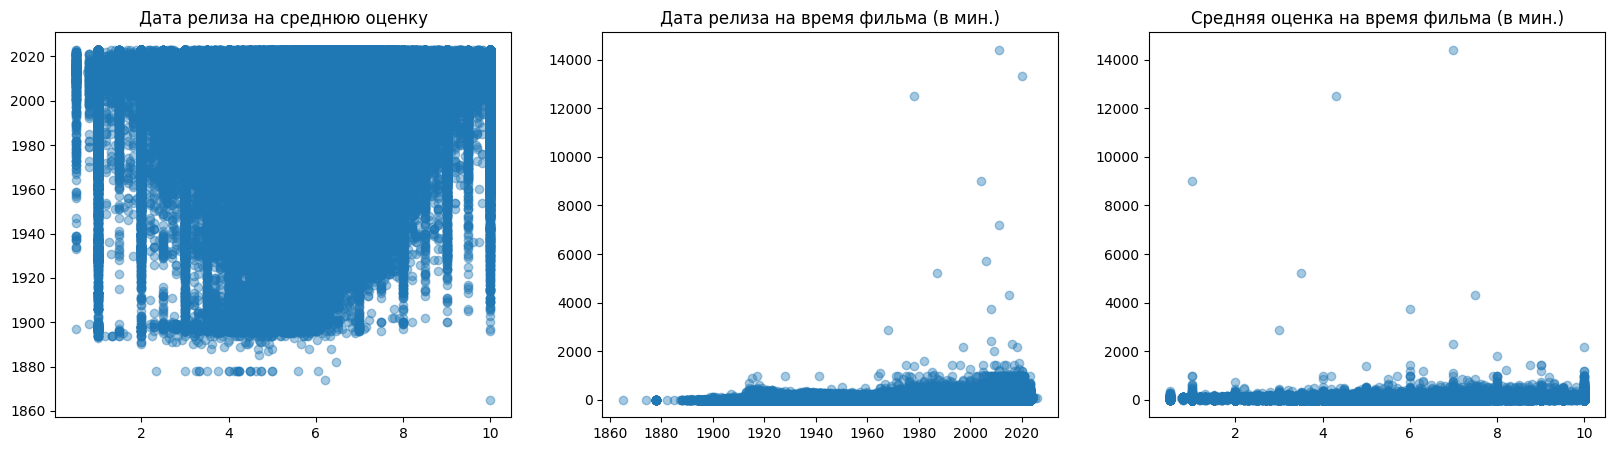

In [43]:
def zero_fun(db, par_1, par_2):
  lpar_1 = []
  lpar_2 = []
  for val_1, val_2 in zip(db[par_1], db[par_2]):
    if val_1 != 0 and val_2 != 0:
      lpar_1.append(val_1)
      lpar_2.append(val_2)
  result = [lpar_1, lpar_2]
  return result

fig, axes = plt.subplots(1, 3, figsize = (20, 5))
tmp = zero_fun(db, 'release_date', 'vote_average')
axes[0].scatter(tmp[1], tmp[0],   alpha = 0.4)
axes[0].set_title('Дата релиза на среднюю оценку')
tmp = zero_fun(db, 'release_date', 'runtime')
axes[1].scatter(tmp[0], tmp[1],   alpha = 0.4)
axes[1].set_title('Дата релиза на время фильма (в мин.)')
tmp = zero_fun(db, 'vote_average', 'runtime')
axes[2].scatter(tmp[0], tmp[1],   alpha = 0.4)
axes[2].set_title('Средняя оценка на время фильма (в мин.)')
plt.show()

Уже тут можно сделать несколько выводов:


1.   Кол-во фильмов и их оценки связаны: чем позже снимали фильмы, тем больше их выходило, увеличивая расброс оценок.
2.   Видна зависимость года выпуска и времени продолжительности. За последние 50 лет продолжительность фильмов возросла.
3.   Средняя оценка не сильно зависит от продолжительности фильма.



Для категориальных признаков найдём основные характеристики.

In [44]:
db.describe(include = ['category'])

,adult,original_language,genres,spoken_languages
count,937626,937626,603504,575614
unique,2,173,12297,6787
top,False,en,Documentary,English
freq,849478,501257,118103,204273


Построим для них диаграмы и посмотрим на первичные результаты.

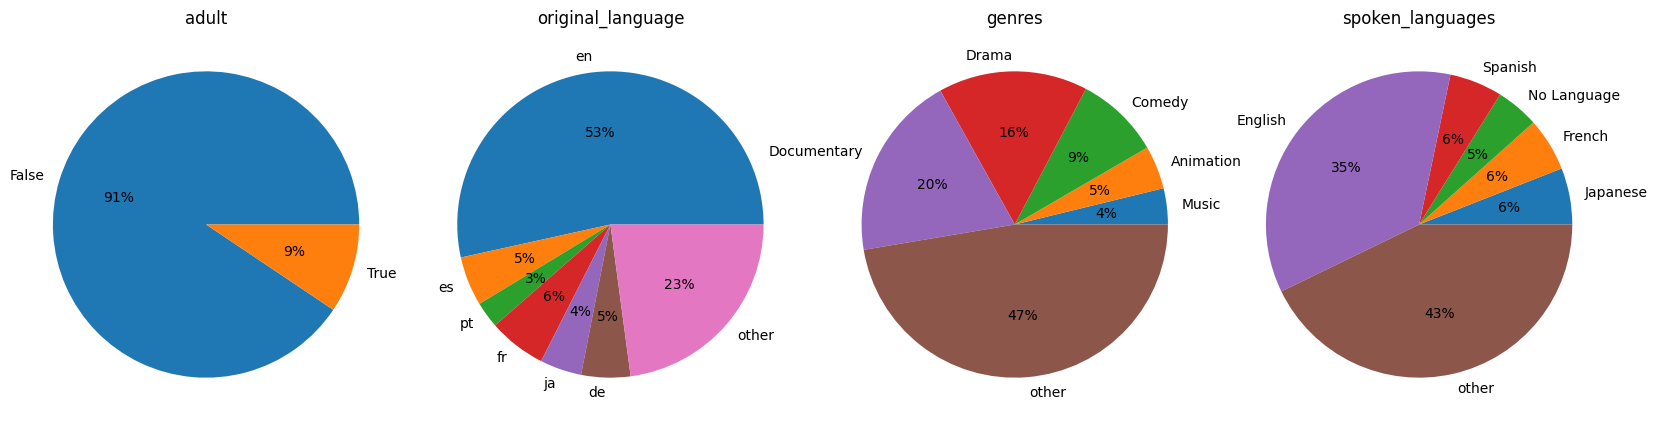

In [45]:
def other_fun(array, array_aply):
  result = []
  for i in array:
    if i not in array_aply:
      result.append('other')
    else:
      result.append(i)
  return result

fig, axes = plt.subplots(1, 4, figsize = (20, 5))

value = db['adult'].value_counts()
adult = value.values
labels = value.index

axes[0].pie(adult, labels=labels, autopct = '%1.0f%%')
axes[0].axis("equal")
axes[0].set_title('adult')

value = db['original_language'].value_counts()
lan = ['en', 'fr', 'es', 'de', 'ja', 'pt']
labels = other_fun(value.index, lan)
zipped = list(zip(labels, value.values))
groupedLabels = list(set(labels))
groupedData = [ sum(v for k, v in zipped if k == n) for n in groupedLabels ]

axes[1].pie(groupedData, labels=groupedLabels, autopct = '%1.0f%%')
axes[1].axis("equal")
axes[1].set_title('original_language')

value = db['genres'].value_counts()
gen = ['Documentary', 'Drama', 'Comedy', 'Animation', 'Music']
labels = other_fun(value.index, gen)
zipped = list(zip(labels, value.values))
groupedLabels = list(set(labels))
groupedData = [ sum(v for k, v in zipped if k == n) for n in groupedLabels ]

axes[2].pie(groupedData, labels=groupedLabels, autopct = '%1.0f%%')
axes[2].axis("equal")
axes[2].set_title('genres')

value = db['spoken_languages'].value_counts()
slen = ['English', 'Japanese', 'French', 'Spanish', 'No Language']
spoken_languages = value.values
labels = other_fun(value.index, slen)
zipped = list(zip(labels, value.values))
groupedLabels = list(set(labels))
groupedData = [ sum(v for k, v in zipped if k == n) for n in groupedLabels ]

axes[3].pie(groupedData, labels=groupedLabels, autopct = '%1.0f%%')
axes[3].axis("equal")
axes[3].set_title('spoken_languages')

plt.show()

По этим диаграммам можно сделать вывод о том, что:


1.   Большенство фильмом нацелено на всю аудиторию, а не только на взрослую
2.   Популярным оригинальным языком фильмов является английский
3.   В жанрах лидируют документальные фильмы без объядинения с другими
4.   В большинствах фильмах актёры говорят на английском языке



# 3) Обработка пропущенных значений

Сперва начнём со столбца "Жанр", потому что не будет иметь смысл обработки фильма с незаволненым жанром.

In [46]:
db = db.dropna(subset=['genres'])
db = db.reset_index(drop=True)
db.head()

,title,vote_average,release_date,runtime,adult,budget,original_language,genres,production_companies,production_countries,spoken_languages
0,Inception,8.364,2010,148,False,160000000,en,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili"
1,Interstellar,8.417,2014,169,False,165000000,en,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English
2,The Dark Knight,8.512,2008,152,False,185000000,en,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin"
3,Avatar,7.573,2009,162,False,237000000,en,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish"
4,The Avengers,7.710,2012,143,False,220000000,en,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian"


In [47]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603504 entries, 0 to 603503
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   title                 603501 non-null  object  
 1   vote_average          603504 non-null  float64 
 2   release_date          603504 non-null  int64   
 3   runtime               603504 non-null  int64   
 4   adult                 603504 non-null  category
 5   budget                603504 non-null  int64   
 6   original_language     603504 non-null  category
 7   genres                603504 non-null  category
 8   production_companies  360101 non-null  object  
 9   production_countries  460797 non-null  object  
 10  spoken_languages      460413 non-null  category
dtypes: category(4), float64(1), int64(3), object(3)
memory usage: 36.9+ MB


Теперь обработаем строки. В начале нужно будет убрать те данные, где рейтинг, дата релиза, время и бюджет фильмов равняется 0, т.к. это будет мешать точно прогнозировать их рейтинг.

In [48]:
db = db.loc[db['vote_average'] != 0]
db = db.loc[db['release_date'] != 0]
db = db.loc[db['runtime'] != 0]
db = db.loc[db['budget'] != 0]

Затем присвоим пустым строкам значение "unknow".

In [49]:
db['title'] = db['title'].fillna('unknow')
db['production_companies'] = db['production_companies'].fillna('unknow')
db['production_countries'] = db['production_countries'].fillna('unknow')
db.iloc[:, 10] = db.iloc[:, 10].astype('object')
db['spoken_languages'] = db['spoken_languages'].fillna('unknow')
db.iloc[:, 10] = db.iloc[:, 10].astype('category')

<ipython-input-49-d84182a33a33>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  db.iloc[:, 10] = db.iloc[:, 10].astype('object')
<ipython-input-49-d84182a33a33>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  db.iloc[:, 10] = db.iloc[:, 10].astype('category')


In [50]:
db.isnull().sum()

title                   0
vote_average            0
release_date            0
runtime                 0
adult                   0
budget                  0
original_language       0
genres                  0
production_companies    0
production_countries    0
spoken_languages        0
dtype: int64

# 4) Обработка колличественных и категориальных признаков

In [51]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23746 entries, 0 to 529097
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   title                 23746 non-null  object  
 1   vote_average          23746 non-null  float64 
 2   release_date          23746 non-null  int64   
 3   runtime               23746 non-null  int64   
 4   adult                 23746 non-null  category
 5   budget                23746 non-null  int64   
 6   original_language     23746 non-null  category
 7   genres                23746 non-null  category
 8   production_companies  23746 non-null  object  
 9   production_countries  23746 non-null  object  
 10  spoken_languages      23746 non-null  category
dtypes: category(4), float64(1), int64(3), object(3)
memory usage: 2.0+ MB


Для начала округлим средний рейтинг и присвоим им целочисленное тип.

In [52]:
float_list = db['vote_average']
result = []
for val in float_list:
  result.append(round(val))
db['vote_average'] = result
db.iloc[:, 2] = db.iloc[:, 2].astype('int64')

array([[<Axes: title={'center': 'vote_average'}>,
        <Axes: title={'center': 'release_date'}>],
       [<Axes: title={'center': 'runtime'}>,
        <Axes: title={'center': 'budget'}>]], dtype=object)

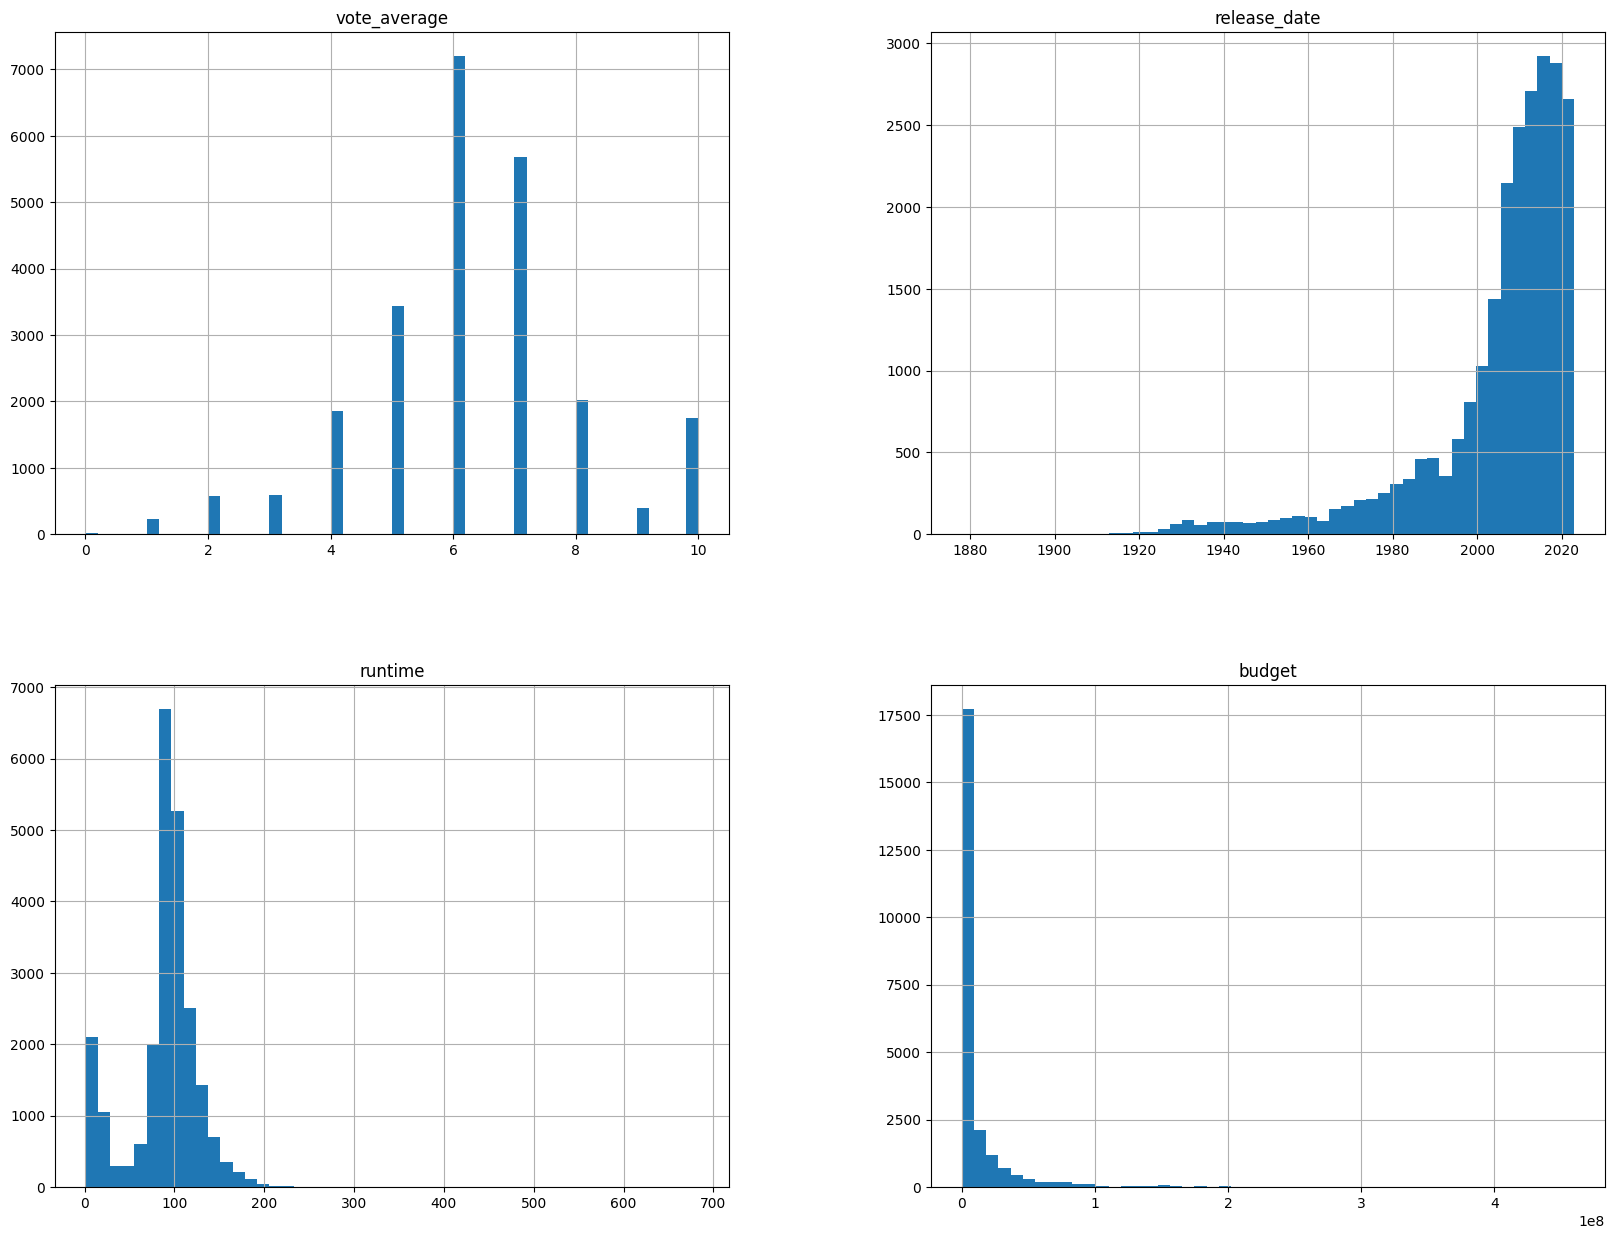

In [53]:
numerical = [i for i in db.columns if db[i].dtype.name != 'object' and db[i].dtype.name != 'category']
db[numerical].hist(figsize=(20,15),bins=50)

В категориальные признаках уберём оригинальный язык и язык озвучки, т.к. это никак не будет задействовать в прогнозировании.
Также сохраним названия фильмов для проверки результатов в конце.

In [54]:
tittle_names = db['title'].copy()
db = db.drop(db.iloc[:, [0, 6, 8, 9, 10]], axis=1)
categorical = [i for i in db.columns if db[i].dtype.name == 'category']
categorical

['adult', 'genres']

In [55]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23746 entries, 0 to 529097
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vote_average  23746 non-null  int64   
 1   release_date  23746 non-null  int64   
 2   runtime       23746 non-null  int64   
 3   adult         23746 non-null  category
 4   budget        23746 non-null  int64   
 5   genres        23746 non-null  category
dtypes: category(2), int64(4)
memory usage: 1.3 MB


Для признака "adult", где типом является бул, присвоим бинарные значения.

In [56]:
db.iloc[:, 3] = db.iloc[:, 3].astype('object')
db.loc[db['adult']== 'False', 'adult'] = 0;
db.loc[db['adult']== 'True', 'adult'] = 1;
db['adult'] = db['adult'].astype(np.int64)
db['adult'].value_counts()

<ipython-input-56-cf65755a7cbc>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  db.iloc[:, 3] = db.iloc[:, 3].astype('object')


0    23659
1       87
Name: adult, dtype: int64

In [57]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23746 entries, 0 to 529097
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vote_average  23746 non-null  int64   
 1   release_date  23746 non-null  int64   
 2   runtime       23746 non-null  int64   
 3   adult         23746 non-null  int64   
 4   budget        23746 non-null  int64   
 5   genres        23746 non-null  category
dtypes: category(1), int64(5)
memory usage: 1.5 MB


Для признака "genres" проведём чтение строки и их бинарной обработки по отдельным столбцам.

In [58]:
genre = db.copy()

genre['genres'] = genre['genres'].str.split(',')
genre = genre.explode('genres')
genre = pd.get_dummies(genre, columns=['genres'])

col = genre.columns.to_list()
genre = genre.drop(genre.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], axis=1)
genre = genre.groupby(level=0).sum()

db = db.drop(db.iloc[:, [5]], axis=1)
db = pd.concat([db, genre], axis=1)

db.iloc[:, list(range(5, 37))] = db.iloc[:, list(range(5, 37))].astype('category')

db.head()

,vote_average,release_date,runtime,adult,budget,genres_ Documentary,genres_ Drama,genres_ Family,genres_ Fantasy,genres_ History,...,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western
0,8,2010,148,0,160000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,2014,169,0,165000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,2008,152,0,185000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,2009,162,0,237000000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,8,2012,143,0,220000000,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [59]:
len(db.columns)

38

Каждый жанр приведём к стандартному целочисленному типу.

In [60]:
db.iloc[:, list(range(5, 38))] = db.iloc[:, list(range(5, 38))].astype('int64')
numerical = [i for i in db.columns if db[i].dtype.name != 'object' and db[i].dtype.name != 'category']
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23746 entries, 0 to 529097
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   vote_average             23746 non-null  int64
 1   release_date             23746 non-null  int64
 2   runtime                  23746 non-null  int64
 3   adult                    23746 non-null  int64
 4   budget                   23746 non-null  int64
 5   genres_ Documentary      23746 non-null  int64
 6   genres_ Drama            23746 non-null  int64
 7   genres_ Family           23746 non-null  int64
 8   genres_ Fantasy          23746 non-null  int64
 9   genres_ History          23746 non-null  int64
 10  genres_ Horror           23746 non-null  int64
 11  genres_ Music            23746 non-null  int64
 12  genres_ Mystery          23746 non-null  int64
 13  genres_ Romance          23746 non-null  int64
 14  genres_ Science Fiction  23746 non-null  int64
 15  g

<ipython-input-60-3e47f6d577bc>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  db.iloc[:, list(range(5, 38))] = db.iloc[:, list(range(5, 38))].astype('int64')


# 5) Нормализация



In [61]:
db.describe()

,vote_average,release_date,runtime,adult,budget,genres_ Documentary,genres_ Drama,genres_ Family,genres_ Fantasy,genres_ History,...,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western
count,23746.000000,23746.000000,23746.000000,23746.000000,2.374600e+04,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,...,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000
mean,6.232292,2005.213425,89.255243,0.003664,1.141317e+07,0.007959,0.186810,0.052935,0.052977,0.033269,...,0.007285,0.116820,0.010823,0.013223,0.024594,0.028594,0.002527,0.052093,0.008043,0.006654
std,1.782424,18.305945,39.241147,0.060419,2.745450e+07,0.088861,0.389876,0.223909,0.223993,0.179341,...,0.085045,0.321212,0.103471,0.114232,0.154886,0.166667,0.050204,0.222219,0.089326,0.081300
min,0.000000,1878.000000,1.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,2001.000000,81.000000,0.000000,4.000000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,2011.000000,94.000000,0.000000,1.354242e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,2017.000000,109.000000,0.000000,1.000000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,2023.000000,683.000000,1.000000,4.600000e+08,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Приведём все целочисленные данные к нормали, путём стандартизации.

In [62]:
data = db[numerical]
db[numerical] = (data - data.mean(axis = 0))/data.std(axis = 0)
db[numerical]

,vote_average,release_date,runtime,adult,budget,genres_ Documentary,genres_ Drama,genres_ Family,genres_ Fantasy,genres_ History,...,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western
0,0.991744,0.261477,1.497019,-0.060639,5.412112,-0.08957,-0.479154,-0.236414,-0.236513,-0.185505,...,-0.085666,-0.363684,-0.104598,-0.115758,-0.158785,-0.171566,-0.050329,-0.234422,-0.090046,-0.081842
1,0.991744,0.479985,2.032172,-0.060639,5.594232,-0.08957,2.085767,-0.236414,-0.236513,-0.185505,...,-0.085666,-0.363684,-0.104598,-0.115758,-0.158785,-0.171566,-0.050329,-0.234422,-0.090046,-0.081842
2,1.552778,0.152222,1.598953,-0.060639,6.322710,-0.08957,-0.479154,-0.236414,-0.236513,-0.185505,...,-0.085666,-0.363684,-0.104598,-0.115758,-0.158785,-0.171566,-0.050329,-0.234422,-0.090046,-0.081842
3,0.991744,0.206849,1.853788,-0.060639,8.216753,-0.08957,-0.479154,-0.236414,4.227912,-0.185505,...,-0.085666,-0.363684,-0.104598,-0.115758,-0.158785,-0.171566,-0.050329,-0.234422,-0.090046,-0.081842
4,0.991744,0.370731,1.369602,-0.060639,7.597546,-0.08957,-0.479154,-0.236414,-0.236513,-0.185505,...,-0.085666,-0.363684,-0.104598,-0.115758,-0.158785,5.828429,-0.050329,-0.234422,-0.090046,-0.081842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430386,0.991744,0.643866,-0.669074,-0.060639,-0.406548,-0.08957,-0.479154,-0.236414,-0.236513,5.390455,...,-0.085666,-0.363684,-0.104598,-0.115758,-0.158785,-0.171566,-0.050329,-0.234422,-0.090046,-0.081842
468258,-0.691357,0.643866,-0.388756,-0.060639,-0.414620,-0.08957,-0.479154,-0.236414,-0.236513,-0.185505,...,-0.085666,2.749524,-0.104598,-0.115758,-0.158785,-0.171566,-0.050329,-0.234422,-0.090046,-0.081842
492418,-1.813425,0.042968,0.375747,-0.060639,-0.380199,-0.08957,-0.479154,-0.236414,-0.236513,-0.185505,...,-0.085666,-0.363684,-0.104598,-0.115758,-0.158785,-0.171566,-0.050329,-0.234422,-0.090046,-0.081842
492748,0.991744,0.316104,0.095429,-0.060639,-0.379288,-0.08957,2.085767,-0.236414,-0.236513,-0.185505,...,-0.085666,-0.363684,-0.104598,-0.115758,-0.158785,-0.171566,-0.050329,-0.234422,-0.090046,-0.081842


# 6) Разбиение данных на обучающуюся и тестовую выборки

Разобьём данные на обучающую и тестовуб выборку.

In [63]:
from sklearn.model_selection import train_test_split

X = data.drop(['vote_average'], axis=1)
y = data['vote_average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(16622, 7124)

# 7) Запуск и поиск оптимального колличества значений ближайших соседей

Для поиска будет использоваться метод ближайших соседей из-за его простоты реализации.

In [64]:
from sklearn import neighbors
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)

0.10523282918717414

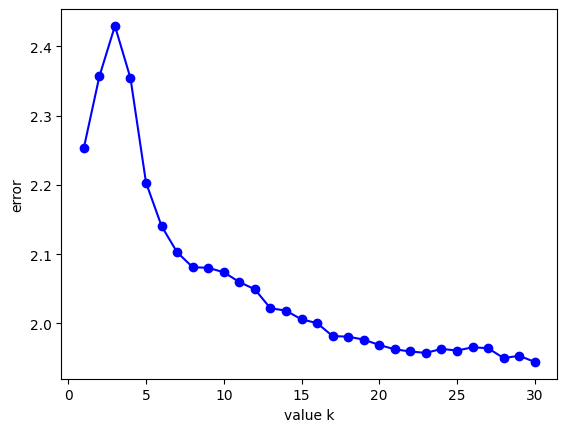

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

error = []

for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    error.append(np.sqrt(mean_squared_error(y_test, y_pred)))

plt.plot(range(1, 31), error, 'b-o')
plt.xlabel('value k')
plt.ylabel('error')
plt.show()

Проверим на ошибки обучающую и тестовую выборку.

In [66]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
knn = KNeighborsRegressor(n_neighbors=28)
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)
print("Train: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Test: ", np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train:  1.5970029227977802
Test:  1.6704535577774344


In [67]:
def аorecast(tittle_name):
    tittle = X[tittle_names == tittle_name]
    result = knn.predict(tittle)
    return result

tittle_name = 'The Dark Knight'
result = аorecast(tittle_name)
print(result)

[6.85714286]


# 8) Вывод
Результат прогнозирования не точный, что можно увидеть по фильму "The Dark Knight". Наш прогноз составил 6.857, когда в используемом датасете было 8.512. Это можно объяснить тем, что не только жанр влияет на рейтинг фильмов, но сопуствующие факторы к съёмке, постпродакшену и выпуску. Это и время выхода: был ли этот фильм единственным блокбастером года или нет, и откуда были взяты данные рейтингов, т.к. в начале фильм могли не оценить, а со временем "потеплеть" к нему, и т.д. Для более точного прогноза рейтинга фильма нужно учитывать всевозможные факторы, потому они тесно взаимосвязанны друг с другом.

# **Лабараторная работа №2 (Продолжение лабараторной №1)**

Реализация логистической регрессии, RandomForest и полносвязной нейронной сети.

## 1) Логистическая реграссия

In [68]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train, y_train)
error_train = np.mean(y_train != LR.predict(X_train))
error_test  = np.mean(y_test  != LR.predict(X_test))
print('Error on train = ', error_train)
print('Error on test = ', error_test)

Error on train =  0.6905306220671399
Error on test =  0.7043795620437956


In [69]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, LR.predict(X_test))
print('Confusion matrix for Logistic Regression:')
print(cm)

Confusion matrix for Logistic Regression:
[[   0    0    0    0    0    0    5    0    0    0    0]
 [   0    0    0    0    0    0   69    0    0    0    0]
 [   0    0    0    0    0    0  163    0    0    0    0]
 [   0    0    0    0    0    0  180    0    0    0    0]
 [   0    0    0    0    0    0  561    0    0    0    0]
 [   0    0    0    0    0    0 1025    8    0    0    0]
 [   0    0    0    0    0    0 2029   56    0    0    0]
 [   0    0    0    0    0    0 1670   77    0    0    0]
 [   0    0    0    0    0    0  576   30    0    0    0]
 [   0    0    0    0    0    0  116    1    0    0    0]
 [   0    0    0    0    0    0  558    0    0    0    0]]


## 2) RandomForest

In [70]:
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
RF = ensemble.RandomForestClassifier(n_estimators = 42)
RF.fit(X_train, y_train)
error_train = np.mean(y_train != RF.predict(X_train))
error_test  = np.mean(y_test  != RF.predict(X_test))
print('Error on train = ', error_train)
print('Error on test = ', error_test)

Error on train =  0.0025267717482854047
Error on test =  0.6626895002807411


In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, RF.predict(X_test))
print('Confusion matrix for Random Forest:')
print(cm)

Confusion matrix for Random Forest:
[[   0    0    0    0    1    0    4    0    0    0    0]
 [   0    0    3    1   10    7   26    9    2    1   10]
 [   0    2    6   14   16   25   48   16   10    2   24]
 [   0    3    7    4   38   40   61   11    6    1    9]
 [   0    6   14   18   81  131  189   78   16    4   24]
 [   0    4   14   26   99  195  475  160   26    4   30]
 [   0    3    4   19   85  290 1022  515   58    5   84]
 [   1    2    7    7   36  113  741  696   73    7   64]
 [   0    3    9    5   17   37  162  212   88    6   67]
 [   0    1    4    1    6    7   29   15    8    2   44]
 [   0   11   14    5   14   27   79   50   34   15  309]]


## 3) Полносвязная нейроная сеть с 1-м открытым слоем

In [72]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'lbfgs',
                          activation = 'logistic',
                          max_iter=1000,
                          random_state = 42)
MLP.fit(X_train, y_train)
error_train = np.mean(y_train != MLP.predict(X_train))
error_test  = np.mean(y_test  != MLP.predict(X_test))
print('Error on train = ', error_train)
print('Error on test = ', error_test)

Error on train =  0.6746480567922031
Error on test =  0.6855699045480067


In [73]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, MLP.predict(X_test))
print('Confusion matrix for Neural Network:')
print(cm)

Confusion matrix for Neural Network:
[[   0    0    0    0    0    0    2    1    0    0    2]
 [   0    0    0    0    0    0   44    6    0    0   19]
 [   0    0    0    0    0    0  120   13    0    0   30]
 [   0    0    0    0    0    0  137   20    0    0   23]
 [   0    0    0    0    0    0  452   37    0    0   72]
 [   0    0    0    0    0    0  919   36    0    0   78]
 [   0    0    0    0    0    0 1869   63    0    0  153]
 [   0    0    0    0    0    0 1610   38    0    0   99]
 [   0    0    0    0    0    0  478   32    0    0   96]
 [   0    0    0    0    0    0   48   13    0    0   56]
 [   0    0    0    0    0    0  162   63    0    0  333]]


## Попробуем найти для нейроной сети значение Alpha и посмотрим зависимость этого параметра от ошибок

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

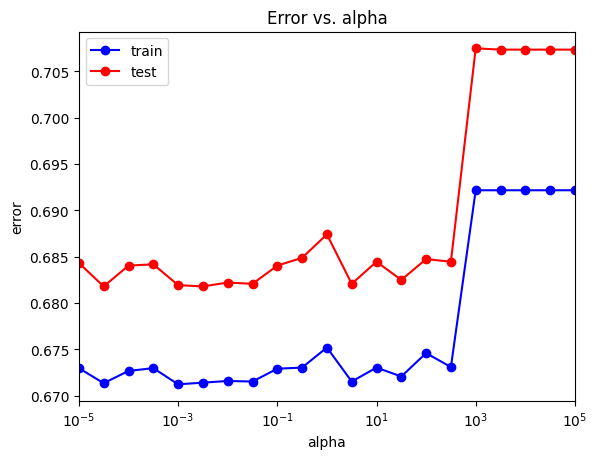

In [76]:
alpha_arr = np.logspace(-5, 5, 21)

train_err = []
test_err = []

for alpha in alpha_arr:
    MLP = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,),
                              solver = 'lbfgs', activation = 'logistic', max_iter=200, random_state = 42)
    MLP.fit(X_train, y_train)

    y_train_pred = MLP.predict(X_train)
    y_test_pred = MLP.predict(X_test)

    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

In [79]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print('Min error on train = ', min_train_err)
print('Min error on test = ', min_test_err)
alpha_arr_opt = alpha_arr[test_err == min_test_err]
print('Optimal number of neurons = ', alpha_arr_opt)

Min error on train =  0.6712188665623872
Min error on test =  0.6817798989331836
Optimal number of neurons =  [3.16227766e-05 3.16227766e-03]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

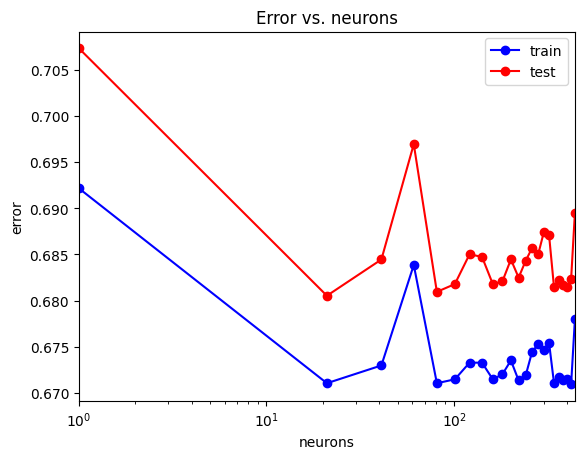

In [82]:
neurons_num = np.array([i for i in range(1, 450, 20)])

train_err, test_err = [], []

for neurons in neurons_num:
    MLP = MLPClassifier(alpha = alpha_arr_opt[0], hidden_layer_sizes = (neurons,),
                              solver = 'lbfgs', activation = 'logistic', max_iter=200, random_state = 42)
    MLP.fit(X_train, y_train)

    y_train_pred = MLP.predict(X_train)
    y_test_pred = MLP.predict(X_test)

    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

plt.semilogx(neurons_num, train_err, 'b-o', label = 'train')
plt.semilogx(neurons_num, test_err, 'r-o', label = 'test')
plt.xlim([np.min(neurons_num), np.max(neurons_num)])
plt.title('Error vs. neurons')
plt.xlabel('neurons')
plt.ylabel('error')
plt.legend()

In [85]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print('Min error on train = ', min_train_err)
print('Min error on test = ', min_test_err)
neurons_num_opt = neurons_num[test_err == min_test_err]
print('Optimal number of neurons = ', neurons_num_opt)

Min error on train =  0.6709180604018771
Min error on test =  0.6805165637282425
Optimal number of neurons =  [21]


# Вывод

В лабараторной работе были применены к исходным данным следуеющие модели: линейная регрессия, RandomForest и Полносвязная нейроная сеть. Также рассмотрели ошибки каждой модели и построили confusion matrix. Ещё была выявлена зависимость между параметром alpha и neurons между ошибками.

Начиная с матриц ошибок, можно сказать, что модели имеёт трудности в правильной классификации. Это может быть связано с несбалансированностью классов или с нормализацией данных на прошлых этапах. Для проверки можно попробовать другой способ нормализации. По результатм, лучше всего себя показала модель RandomForest.

Для нейронной сети были найдены оптимальные параметры alpha и neurons. В графиках можно заметить, погрешность в вычислениях. Также заметно, что модель работает на обучающих данных лучше, чем на тестовых и происходит переобучение. Можно предположить, что это происходит из-за "подгонки" модели к обучающим данным, улавливая шумы в данных.